In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from time import time
from pathlib import Path
from tqdm import tqdm
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn
from torch.utils.data import random_split
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchmetrics.classification import MultilabelF1Score
from torchmetrics.classification import MultilabelAccuracy
from transformers import BertModel, BertTokenizer
from Bio import SeqIO

In [36]:
torch.manual_seed(42)
np.random.seed(42)
torch.cuda.manual_seed_all(42)

In [37]:
class config:
    num_labels = 500
    n_epochs = 14
    batch_size = 64
    lr = 0.001
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    embeds_dim = 1024

In [38]:
class paths:
    train_ids = "/kaggle/input/t5embeds/train_ids.npy"    
    train_embeddings = "/kaggle/input/t5embeds/train_embeds.npy"
    test_ids = "/kaggle/input/t5embeds/test_ids.npy"
    test_embeddings = "/kaggle/input/t5embeds/test_embeds.npy"
    train_labels_path = "/kaggle/input/cafa-5-protein-function-prediction/Train/train_terms.tsv"
    train_targets_path = "/kaggle/input/cafa5-label-vectors-numpy/train_targets_top500.npy"

In [39]:
class CustomProteinDataset(Dataset):
    def __init__(self, train=True):
        super(CustomProteinDataset).__init__()
        self.train=train
        if train:
            embeds = np.load(paths.train_embeddings)
            ids = np.load(paths.train_ids)
        else:
            embeds = np.load(paths.test_embeddings)
            ids = np.load(paths.test_ids)
        
        embeds_list = []
        for l in range(embeds.shape[0]):
            embeds_list.append(embeds[l,:])
        self.df = pd.DataFrame(data={"EntryID": ids, "embed" : embeds_list})
        
        if train:
            self.labels = np.load(paths.train_targets_path)
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        embed = torch.tensor(self.df.iloc[index]["embed"], dtype = torch.float32)
        if self.train:
            targets = torch.tensor(self.labels[index, :], dtype = torch.float32)
            return embed, targets
        else:
            id = self.df.iloc[index]["EntryID"]
            return embed, id

In [40]:
train_dataset = CustomProteinDataset()
test_dataset = CustomProteinDataset(train=False)

In [41]:
len(train_dataset)

142246

In [42]:
class MultiLayerPerceptron(torch.nn.Module):
    def __init__(self, input_dim, num_classes):
        super(MultiLayerPerceptron, self).__init__()
        self.linear1 = torch.nn.Linear(input_dim, 1012)
        self.activation1 = torch.nn.ReLU()
        self.linear2 = torch.nn.Linear(1012, 712)
        self.activation2 = torch.nn.ReLU()
        self.linear3 = torch.nn.Linear(712, num_classes)

    def forward(self, x):
        x = self.linear1(x)
        x = self.activation1(x)
        x = self.linear2(x)
        x = self.activation2(x)
        x = self.linear3(x)
        return x

In [43]:
class CNN1D(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(CNN1D, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=3, kernel_size=3, dilation=1, padding=1, stride=1)
        self.pool1 = nn.MaxPool1d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv1d(in_channels=3, out_channels=8, kernel_size=3, dilation=1, padding=1, stride=1)
        self.pool2 = nn.MaxPool1d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(in_features=int(8 * input_dim/4), out_features=128)
        self.fc2 = nn.Linear(in_features=128, out_features=num_classes)

    def forward(self, x):
        x = x.reshape(x.shape[0], 1, x.shape[1])
        x = self.pool1(nn.functional.relu(self.conv1(x)))
        x = self.pool2(nn.functional.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = nn.functional.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [44]:
def train(model_type="linear", train_size=0.9):
    train_set, val_set = random_split(train_dataset, lengths = [int(len(train_dataset)*train_size), len(train_dataset)-int(len(train_dataset)*train_size)])
    train_dataloader = DataLoader(train_set, batch_size=config.batch_size, shuffle=True)
    val_dataloader = DataLoader(val_set, batch_size=config.batch_size, shuffle=True)
    
    if model_type == "linear":
        model = MultiLayerPerceptron(input_dim=config.embeds_dim, num_classes=config.num_labels).to(config.device)
    if model_type == "convolutional":
        model = CNN1D(input_dim=config.embeds_dim, num_classes=config.num_labels).to(config.device)
        
    optimizer = torch.optim.Adam(model.parameters(), lr = config.lr)
    scheduler = ReduceLROnPlateau(optimizer, factor=0.1, patience=1)
    CrossEntropy = torch.nn.CrossEntropyLoss()
    f1_score = MultilabelF1Score(num_labels=config.num_labels).to(config.device)
    n_epochs = config.n_epochs
    
    train_loss_history=[]
    val_loss_history=[]
    
    train_f1score_history=[]
    val_f1score_history=[]
    
    for epoch in range(n_epochs):
        print("EPOCH ", epoch+1)
        ## TRAIN PHASE :
        losses = []
        scores = []
        for embed, targets in tqdm(train_dataloader):
            embed, targets = embed.to(config.device), targets.to(config.device)
            optimizer.zero_grad()
            preds = model(embed)
            loss= CrossEntropy(preds, targets)
            score=f1_score(preds, targets)
            losses.append(loss.item()) 
            scores.append(score.item())
            loss.backward()
            optimizer.step()
        avg_loss = np.mean(losses)
        avg_score = np.mean(scores)
        print("Running Average TRAIN Loss : ", avg_loss)
        print("Running Average TRAIN F1-Score : ", avg_score)
        train_loss_history.append(avg_loss)
        train_f1score_history.append(avg_score)\
        
        losses = []
        scores = []
        for embed, targets in val_dataloader:
            embed, targets = embed.to(config.device), targets.to(config.device)
            preds = model(embed)
            loss= CrossEntropy(preds, targets)
            score=f1_score(preds, targets)
            losses.append(loss.item())
            scores.append(score.item())
        avg_loss = np.mean(losses)
        avg_score = np.mean(scores)
        print("Running Average VAL Loss : ", avg_loss)
        print("Running Average VAL F1-Score : ", avg_score)
        val_loss_history.append(avg_loss)
        val_f1score_history.append(avg_score)
        
        scheduler.step(avg_loss)
        print("\n")
        
    print("TRAINING FINISHED")
    print("FINAL TRAINING SCORE : ", train_f1score_history[-1])
    print("FINAL VALIDATION SCORE : ", val_f1score_history[-1])
    
    losses_history = {"train" : train_loss_history, "val" : val_loss_history}
    scores_history = {"train" : train_f1score_history, "val" : val_f1score_history}
    
    return model, losses_history, scores_history

In [45]:
model, losses_history, scores_history = train(model_type="linear", train_size=0.90)

EPOCH  1


100%|██████████| 2001/2001 [00:16<00:00, 124.13it/s]


Running Average TRAIN Loss :  130.65247114296855
Running Average TRAIN F1-Score :  0.17025186014973717
Running Average VAL Loss :  127.74726682928112
Running Average VAL F1-Score :  0.19288346418618088


EPOCH  2


100%|██████████| 2001/2001 [00:16<00:00, 120.29it/s]


Running Average TRAIN Loss :  126.9959527224913
Running Average TRAIN F1-Score :  0.20178803272065016
Running Average VAL Loss :  126.39057621293004
Running Average VAL F1-Score :  0.2070648364154747


EPOCH  3


100%|██████████| 2001/2001 [00:15<00:00, 125.52it/s]


Running Average TRAIN Loss :  125.35414980269265
Running Average TRAIN F1-Score :  0.21620492846041783
Running Average VAL Loss :  125.69501509046341
Running Average VAL F1-Score :  0.21655610303975006


EPOCH  4


100%|██████████| 2001/2001 [00:16<00:00, 120.40it/s]


Running Average TRAIN Loss :  123.96428420387585
Running Average TRAIN F1-Score :  0.2293377994582511
Running Average VAL Loss :  124.52205415050011
Running Average VAL F1-Score :  0.2249441974098907


EPOCH  5


100%|██████████| 2001/2001 [00:16<00:00, 124.72it/s]


Running Average TRAIN Loss :  122.72522005827531
Running Average TRAIN F1-Score :  0.24237689093641493
Running Average VAL Loss :  124.23942552232955
Running Average VAL F1-Score :  0.23429149382584832


EPOCH  6


100%|██████████| 2001/2001 [00:16<00:00, 121.19it/s]


Running Average TRAIN Loss :  121.53819496044214
Running Average TRAIN F1-Score :  0.253745307368615
Running Average VAL Loss :  124.38532137336217
Running Average VAL F1-Score :  0.2383935992092295


EPOCH  7


100%|██████████| 2001/2001 [00:16<00:00, 123.35it/s]


Running Average TRAIN Loss :  120.48374087568642
Running Average TRAIN F1-Score :  0.2641595555567134
Running Average VAL Loss :  124.34942524315531
Running Average VAL F1-Score :  0.24675938654106294


EPOCH  8


100%|██████████| 2001/2001 [00:16<00:00, 121.12it/s]


Running Average TRAIN Loss :  118.0339061502574
Running Average TRAIN F1-Score :  0.28184810061117577
Running Average VAL Loss :  123.52541484747232
Running Average VAL F1-Score :  0.25355544398985636


EPOCH  9


100%|██████████| 2001/2001 [00:16<00:00, 120.40it/s]


Running Average TRAIN Loss :  117.48274115810747
Running Average TRAIN F1-Score :  0.2875175635883774
Running Average VAL Loss :  123.58228346478244
Running Average VAL F1-Score :  0.25578997013547494


EPOCH  10


100%|██████████| 2001/2001 [00:16<00:00, 124.39it/s]


Running Average TRAIN Loss :  117.1744983640687
Running Average TRAIN F1-Score :  0.2914361693393225
Running Average VAL Loss :  123.74717828724951
Running Average VAL F1-Score :  0.25758570940505227


EPOCH  11


100%|██████████| 2001/2001 [00:16<00:00, 120.35it/s]


Running Average TRAIN Loss :  116.76128795801074
Running Average TRAIN F1-Score :  0.2946190382691397
Running Average VAL Loss :  123.52831617278369
Running Average VAL F1-Score :  0.25822446612231936


EPOCH  12


100%|██████████| 2001/2001 [00:16<00:00, 123.58it/s]


Running Average TRAIN Loss :  116.743900076024
Running Average TRAIN F1-Score :  0.29499032788875995
Running Average VAL Loss :  123.6310642396388
Running Average VAL F1-Score :  0.2582895616779413


EPOCH  13


100%|██████████| 2001/2001 [00:16<00:00, 121.30it/s]


Running Average TRAIN Loss :  116.6685438980644
Running Average TRAIN F1-Score :  0.2955934067239528
Running Average VAL Loss :  123.76048518296315
Running Average VAL F1-Score :  0.2589902237659078


EPOCH  14


100%|██████████| 2001/2001 [00:16<00:00, 122.58it/s]


Running Average TRAIN Loss :  116.66181209932144
Running Average TRAIN F1-Score :  0.29597750187724425
Running Average VAL Loss :  123.54329585601396
Running Average VAL F1-Score :  0.25936058985545496


TRAINING FINISHED
FINAL TRAINING SCORE :  0.29597750187724425
FINAL VALIDATION SCORE :  0.25936058985545496


In [46]:
def predict():
    test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False)
        
    model.eval()
    
    labels = pd.read_csv(paths.train_labels_path, sep = "\t")
    top_terms = labels.groupby("term")["EntryID"].count().sort_values(ascending=False)
    labels_names = top_terms[:config.num_labels].index.values
    print("GENERATE PREDICTION FOR TEST SET...")

    ids_ = np.empty(shape=(len(test_dataloader)*config.num_labels,), dtype=object)
    go_terms_ = np.empty(shape=(len(test_dataloader)*config.num_labels,), dtype=object)
    confs_ = np.empty(shape=(len(test_dataloader)*config.num_labels,), dtype=np.float32)

    for i, (embed, id) in tqdm(enumerate(test_dataloader)):
        embed = embed.to(config.device)
        confs_[i*config.num_labels:(i+1)*config.num_labels] = torch.nn.functional.sigmoid(model(embed)).squeeze().detach().cpu().numpy()
        ids_[i*config.num_labels:(i+1)*config.num_labels] = id[0]
        go_terms_[i*config.num_labels:(i+1)*config.num_labels] = labels_names

    submission_df = pd.DataFrame(data={"Id" : ids_, "GO term" : go_terms_, "Confidence" : confs_})
    print("PREDICTIONS DONE")
    return submission_df

In [47]:
submission_df = predict()

GENERATE PREDICTION FOR TEST SET...


141865it [01:28, 1602.66it/s]


PREDICTIONS DONE


In [48]:
submission_df.head(50)

,Id,GO term,Confidence
0,Q9CQV8,GO:0005575,0.889981
1,Q9CQV8,GO:0008150,0.878727
2,Q9CQV8,GO:0110165,0.888928
3,Q9CQV8,GO:0003674,0.918041
4,Q9CQV8,GO:0005622,0.887782
5,Q9CQV8,GO:0009987,0.836141
6,Q9CQV8,GO:0043226,0.837266
7,Q9CQV8,GO:0043229,0.815397
8,Q9CQV8,GO:0005488,0.909604
9,Q9CQV8,GO:0043227,0.843232


In [49]:
len(submission_df)

70932500

In [50]:
submission_df.to_csv('submission.tsv', sep='\t', index=False)

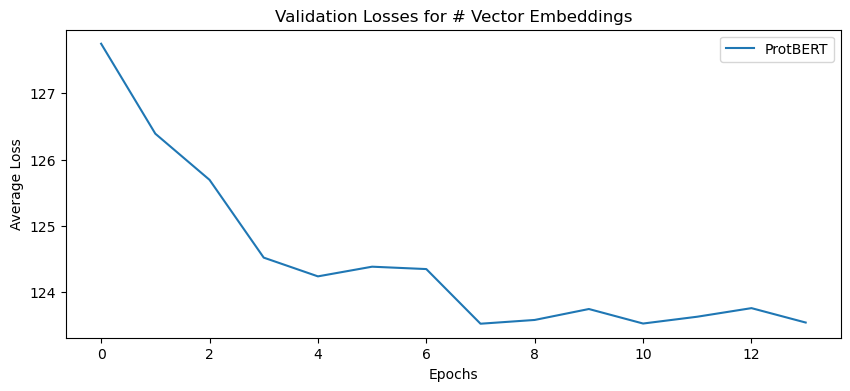

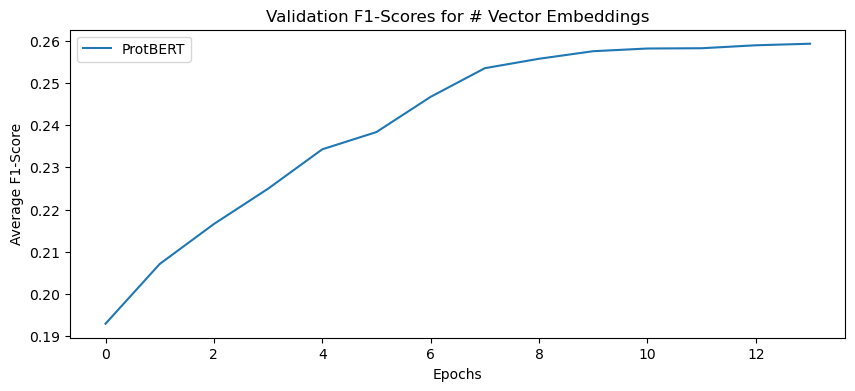

In [51]:
plt.figure(figsize = (10, 4))
plt.plot(losses_history["val"], label = "ProtBERT")
plt.title("Validation Losses for # Vector Embeddings")
plt.xlabel("Epochs")
plt.ylabel("Average Loss")
plt.legend()
plt.show()

plt.figure(figsize = (10, 4))
plt.plot(scores_history["val"], label = "ProtBERT")
plt.title("Validation F1-Scores for # Vector Embeddings")
plt.xlabel("Epochs")
plt.ylabel("Average F1-Score")
plt.legend()
plt.show()